# Глубинное обучение в анализе графовых данных, ПМИ ВШЭ

## Семинар 7

## Масштабирование графовых нейронных сетей

До сих пор мы обучали нейронные сети для задач классификации узлов исключительно в full-batch режиме.
В частности, это означает, что скрытое представление каждого узла вычислялось параллельно и было доступно для повторного использования на следующем уровне.

Однако, как только мы хотим работать с большими графами, эта схема становится неприменимой, поскольку потребление памяти резко возрастает.
Например, граф с примерно 10 миллионами узлов и размерностью скрытых признаков 128 уже потребляет около **5 ГБ памяти графического процессора для каждого слоя**.

**Deep Graph Library (DGL)** — это библиотека Python, созданная для простой реализации моделей графовых нейронных сетей поверх существующих сред DL (в настоящее время поддерживающих PyTorch, MXNet и TensorFlow). Она предлагает универсальный контроль передачи сообщений, оптимизацию скорости с помощью автоматической batch обработки и поддержку разреженных матриц, а также обучение на нескольких GPU/CPU для масштабирования графов с сотнями миллионов узлов и ребер.

In [26]:
# import torch

# !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install dgl-cu113 dglgo -f https://data.dgl.ai/wheels/repo.html
# !pip install ogb

### Neighbor Sampling for GNN Training

![](https://data.dgl.ai/tutorial/img/sampling.gif)

Видно, что для вычисления 5 узла из второго уровня требуются представления первого слоя его соседей (выделены желтым), которые, в свою очередь, нуждаются в представлениях их соседей (то есть соседей узла 5 по второму узлу) (выделены зеленым цветом).

Также видно, что представление для небольшого числа узлов часто требует входных признаков значительно большего числа узлов. Взятие всех соседей для агрегации сообщений часто обходится слишком дорого, поскольку вершины, необходимые для входных функций, легко покрывают большую часть графа, особенно для реальных графов, которые часто не масштабируются.

Выборка соседей решает эту проблему, выбирая подмножество соседей для выполнения агрегирования. Например, чтобы вычислить $h^{(2)}_5$, можно выбрать двух соседей вместо всех для агрегирования, как в следующей анимации:

![](https://data.dgl.ai/tutorial/img/bipartite.gif)

Этот метод использует гораздо меньше узлов, необходимых для передачи сообщений для одного мини-батча.

Также вычислительные зависимости в анимации выше можно описать как серию двудольных графов. Выходные узлы (называемые узлами назначения) находятся на одной стороне, а все узлы, необходимые для ввода (называемые исходными узлами), — на другой стороне. Стрелки показывают, как выбранные соседи передают сообщения узлам. DGL называет такие графы графами потока сообщений (MFG).

In [2]:
import dgl
import torch
import numpy as np
from ogb.nodeproppred import DglNodePropPredDataset

import warnings
warnings.filterwarnings("ignore")

dataset = DglNodePropPredDataset('ogbn-arxiv')  # 'ogbn-mag'
device = 'cuda'

In [3]:
graph, node_labels = dataset[0]
# Add reverse edges since ogbn-arxiv is unidirectional.
graph = dgl.add_reverse_edges(graph)
graph.ndata['label'] = node_labels[:, 0]
print(graph)
print(node_labels)

node_features = graph.ndata['feat']
num_features = node_features.shape[1]
num_classes = (node_labels.max() + 1).item()
print('Number of classes:', num_classes)

Graph(num_nodes=169343, num_edges=2332486,
      ndata_schemes={'year': Scheme(shape=(1,), dtype=torch.int64), 'feat': Scheme(shape=(128,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})
tensor([[ 4],
        [ 5],
        [28],
        ...,
        [10],
        [ 4],
        [ 1]])
Number of classes: 40


In [4]:
idx_split = dataset.get_idx_split()
train_nids = idx_split['train']
valid_nids = idx_split['valid']
test_nids = idx_split['test']

DGL предоставляет инструменты для перебора набора данных в мини-батчах при создании вычислительных зависимостей для вычисления их выходных данных с помощью приведенных выше MFG. Для классификации узлов можно использовать ```dgl.dataloading.DataLoader``` для перебора набора данных. Он принимает объект сэмплера для управления, как генерировать вычислительные зависимости в форме MFG. DGL предоставляет реализации общих алгоритмов выборки, таких как ```dgl.dataloading.NeighborSampler```, который случайным образом выбирает фиксированное количество соседей для каждого узла.

Синтаксис ```dgl.dataloading.DataLoader``` похож на PyTorch DataLoader, за исключением того, что ему нужен граф для создания вычислительной зависимости, набор идентификаторов узлов для итерации и определенный вами сэмплер.

Допустим, каждая вершина будет собирать сообщения от 4-х соседей на каждом слое. Код, определяющий dataloader и сэмплер соседей, будет выглядеть следующим образом:

In [5]:
sampler = dgl.dataloading.NeighborSampler([4, 4])
train_dataloader = dgl.dataloading.DataLoader(
    # The following arguments are specific to DGL's DataLoader.
    graph,              # The graph
    train_nids,         # The node IDs to iterate over in minibatches
    sampler,            # The neighbor sampler
    device=device,      # Put the sampled MFGs on CPU or GPU
    # The following arguments are inherited from PyTorch DataLoader.
    batch_size=1024,    # Batch size
    shuffle=True,       # Whether to shuffle the nodes for every epoch
    drop_last=False,    # Whether to drop the last incomplete batch
    num_workers=0       # Number of sampler processes
)

In [6]:
input_nodes, output_nodes, mfgs = example_minibatch = next(iter(train_dataloader))
print(example_minibatch)
print("To compute {} nodes' outputs, we need {} nodes' input features".format(len(output_nodes), len(input_nodes)))

[tensor([ 11969, 119209,  32097,  ..., 158450,  99417, 119204], device='cuda:0'), tensor([ 11969, 119209,  32097,  ..., 128459,  76562,  49214], device='cuda:0'), [Block(num_src_nodes=12637, num_dst_nodes=4045, num_edges=14556), Block(num_src_nodes=4045, num_dst_nodes=1024, num_edges=3242)]]
To compute 1024 nodes' outputs, we need 12637 nodes' input features


DataLoader DGL дает нам три объекта на итерацию.

- ID Тензор для входных узлов, т. е. узлов, чьи входные признаки необходимы на первом слое GNN для этого мини-батча.
- ID Тензор для выходных узлов, т. е. узлов, представления которых должны быть вычислены.
- Список MFG, в которых хранятся зависимости вычислений для каждого слоя GNN.

Вы можете получить идентификаторы исходного и целевого узлов MFG и убедиться, что первые несколько исходных узлов всегда совпадают с целевыми узлами.

In [7]:
mfg_0_src = mfgs[0].srcdata[dgl.NID]
mfg_0_dst = mfgs[0].dstdata[dgl.NID]
print(mfg_0_src)
print(mfg_0_dst)
print(torch.equal(mfg_0_src[:mfgs[0].num_dst_nodes()], mfg_0_dst))

tensor([ 11969, 119209,  32097,  ..., 158450,  99417, 119204], device='cuda:0')
tensor([ 11969, 119209,  32097,  ...,   3123,  48935,  80979], device='cuda:0')
True


In [8]:
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import SAGEConv


class Model(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(Model, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, aggregator_type='mean')
        self.conv2 = SAGEConv(h_feats, num_classes, aggregator_type='mean')
        self.h_feats = h_feats

    def forward(self, mfgs, x):
        h_dst = x[:mfgs[0].num_dst_nodes()]
        h = self.conv1(mfgs[0], (x, h_dst))
        h = F.relu(h)
        h_dst = h[:mfgs[1].num_dst_nodes()]
        h = self.conv2(mfgs[1], (h, h_dst))
        return h


model = Model(num_features, 128, num_classes).to(device)

In [9]:
opt = torch.optim.Adam(model.parameters())

In [10]:
valid_dataloader = dgl.dataloading.DataLoader(
    graph, valid_nids, sampler,
    batch_size=1024,
    shuffle=False,
    drop_last=False,
    num_workers=0,
    device=device
)

In [11]:
import tqdm
import sklearn.metrics

best_accuracy = 0
best_model_path = 'model.pt'
for epoch in range(30):
    model.train()

    with tqdm.tqdm(train_dataloader) as tq:
        for step, (input_nodes, output_nodes, mfgs) in enumerate(tq):
            # feature copy from CPU to GPU takes place here
            inputs = mfgs[0].srcdata['feat']
            labels = mfgs[-1].dstdata['label']

            predictions = model(mfgs, inputs)

            loss = F.cross_entropy(predictions, labels)
            opt.zero_grad()
            loss.backward()
            opt.step()

            accuracy = sklearn.metrics.accuracy_score(labels.cpu().numpy(), predictions.argmax(1).detach().cpu().numpy())

            tq.set_postfix({'loss': '%.03f' % loss.item(), 'acc': '%.03f' % accuracy}, refresh=False)

    model.eval()

    predictions = []
    labels = []
    with tqdm.tqdm(valid_dataloader) as tq, torch.no_grad():
        for input_nodes, output_nodes, mfgs in tq:
            inputs = mfgs[0].srcdata['feat']
            labels.append(mfgs[-1].dstdata['label'].cpu().numpy())
            predictions.append(model(mfgs, inputs).argmax(1).cpu().numpy())
        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        accuracy = sklearn.metrics.accuracy_score(labels, predictions)
        print('Epoch {} Validation Accuracy {}'.format(epoch, accuracy))
        if best_accuracy < accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), best_model_path)

100%|██████████| 30/30 [00:00<00:00, 51.64it/s]


Epoch 0 Validation Accuracy 0.551729923822947


100%|██████████| 30/30 [00:00<00:00, 52.26it/s]


Epoch 1 Validation Accuracy 0.6150541964495453


100%|██████████| 30/30 [00:00<00:00, 53.71it/s]


Epoch 2 Validation Accuracy 0.6314641430920501


100%|██████████| 30/30 [00:00<00:00, 52.15it/s]


Epoch 3 Validation Accuracy 0.6382093358837545


100%|██████████| 30/30 [00:00<00:00, 40.30it/s]


Epoch 4 Validation Accuracy 0.6400550354038727


100%|██████████| 30/30 [00:00<00:00, 52.70it/s]


Epoch 5 Validation Accuracy 0.6462297392529951


100%|██████████| 30/30 [00:00<00:00, 49.91it/s]


Epoch 6 Validation Accuracy 0.656800563777308


100%|██████████| 30/30 [00:00<00:00, 51.57it/s]


Epoch 7 Validation Accuracy 0.6612638007986845


100%|██████████| 30/30 [00:00<00:00, 52.25it/s]


Epoch 8 Validation Accuracy 0.6596530084902178


100%|██████████| 30/30 [00:00<00:00, 52.61it/s]


Epoch 9 Validation Accuracy 0.6678076445518306


100%|██████████| 30/30 [00:00<00:00, 51.53it/s]


Epoch 10 Validation Accuracy 0.6640155709923152


100%|██████████| 30/30 [00:00<00:00, 52.03it/s]


Epoch 11 Validation Accuracy 0.6650558743581999


100%|██████████| 30/30 [00:00<00:00, 53.68it/s]


Epoch 12 Validation Accuracy 0.6678412027249236


100%|██████████| 30/30 [00:00<00:00, 54.72it/s]


Epoch 13 Validation Accuracy 0.6687472733984362


100%|██████████| 30/30 [00:00<00:00, 52.49it/s]


Epoch 14 Validation Accuracy 0.6658612705124333


100%|██████████| 30/30 [00:00<00:00, 52.89it/s]


Epoch 15 Validation Accuracy 0.665089432531293


100%|██████████| 30/30 [00:00<00:00, 53.18it/s]


Epoch 16 Validation Accuracy 0.6718681834960905


100%|██████████| 30/30 [00:00<00:00, 52.00it/s]


Epoch 17 Validation Accuracy 0.671566159938253


100%|██████████| 30/30 [00:00<00:00, 54.36it/s]


Epoch 18 Validation Accuracy 0.6702238330145307


100%|██████████| 30/30 [00:00<00:00, 52.25it/s]


Epoch 19 Validation Accuracy 0.6770697003255143


100%|██████████| 30/30 [00:01<00:00, 29.27it/s]


Epoch 20 Validation Accuracy 0.6755260243632336


100%|██████████| 30/30 [00:00<00:00, 38.43it/s]


Epoch 21 Validation Accuracy 0.6684452498405987


100%|██████████| 30/30 [00:00<00:00, 53.12it/s]


Epoch 22 Validation Accuracy 0.6804926339810061


100%|██████████| 30/30 [00:00<00:00, 48.84it/s]


Epoch 23 Validation Accuracy 0.67394879022786


100%|██████████| 30/30 [00:00<00:00, 51.69it/s]


Epoch 24 Validation Accuracy 0.6771032584986073


100%|██████████| 30/30 [00:00<00:00, 51.23it/s]


Epoch 25 Validation Accuracy 0.6807275411926574


100%|██████████| 30/30 [00:00<00:00, 52.74it/s]


Epoch 26 Validation Accuracy 0.6725057887848586


100%|██████████| 30/30 [00:00<00:00, 32.40it/s]


Epoch 27 Validation Accuracy 0.6787811671532602


100%|██████████| 30/30 [00:00<00:00, 52.99it/s]


Epoch 28 Validation Accuracy 0.6797207959998658


100%|██████████| 30/30 [00:00<00:00, 52.73it/s]

Epoch 29 Validation Accuracy 0.6793180979227491


In [12]:
print(round(torch.cuda.max_memory_allocated()/1024/1024, 3), 'mb')

59.34 mb


In [13]:
g, node_labels = dataset[0]
g = dgl.add_reverse_edges(g)
g.ndata['label'] = node_labels[:, 0]

In [14]:
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import SAGEConv


class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, aggregator_type='mean')
        self.conv2 = SAGEConv(h_feats, num_classes, aggregator_type='mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Create the model with given dimensions
model = GCN(num_features, 128, dataset.num_classes)

In [16]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0
    g = g.to(device)
    features = g.ndata['feat'].to(device)
    labels = g.ndata['label'].to(device)
    idx_split = dataset.get_idx_split()
    train_mask = idx_split['train']
    val_mask = idx_split['valid']
    test_mask = idx_split['test']
    
    for e in range(100):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()

        # Save the best validation accuracy
        if best_val_acc < val_acc:
            best_val_acc = val_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if e % 5 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc))
            

model = GCN(g.ndata['feat'].shape[1], 128, dataset.num_classes).to(device)
train(g, model)

In epoch 0, loss: 4.073, val acc: 0.004 (best 0.004)
In epoch 5, loss: 2.610, val acc: 0.349 (best 0.378)
In epoch 10, loss: 2.178, val acc: 0.458 (best 0.458)
In epoch 15, loss: 1.877, val acc: 0.535 (best 0.535)
In epoch 20, loss: 1.670, val acc: 0.562 (best 0.562)
In epoch 25, loss: 1.524, val acc: 0.592 (best 0.592)
In epoch 30, loss: 1.427, val acc: 0.605 (best 0.605)
In epoch 35, loss: 1.357, val acc: 0.617 (best 0.617)
In epoch 40, loss: 1.304, val acc: 0.628 (best 0.629)
In epoch 45, loss: 1.263, val acc: 0.634 (best 0.634)
In epoch 50, loss: 1.232, val acc: 0.641 (best 0.642)
In epoch 55, loss: 1.206, val acc: 0.647 (best 0.647)
In epoch 60, loss: 1.184, val acc: 0.651 (best 0.651)
In epoch 65, loss: 1.166, val acc: 0.654 (best 0.654)
In epoch 70, loss: 1.151, val acc: 0.658 (best 0.658)
In epoch 75, loss: 1.137, val acc: 0.660 (best 0.660)
In epoch 80, loss: 1.125, val acc: 0.663 (best 0.663)
In epoch 85, loss: 1.114, val acc: 0.664 (best 0.664)
In epoch 90, loss: 1.104, val 

In [17]:
print(round(torch.cuda.max_memory_allocated()/1024/1024, 3), 'mb')

650.316 mb


In [ ]:
# num_parts = 1000
# sampler = dgl.dataloading.ClusterGCNSampler(g, num_parts)
# dataloader = dgl.dataloading.DataLoader(
#     g, torch.arange(num_parts), sampler,
#     batch_size=20, shuffle=True, drop_last=False, num_workers=4)

# for subg in dataloader:
#     # train_on(subg)
#     pass

### Cluster-GCN

Еще один из подходов известен как **Cluster-GCN** ([Chiang et al. (2019)](https://arxiv.org/abs/1905.07953), который основан на предварительном разбиении графа на подграфы которые можно обрабатывать в мини-батч режиме.

Чтобы продемонстрировать, давайте загрузим график «PubMed» из набора тестов классификации узлов «Planetoid» ([Yang et al. (2016)](https://arxiv.org/abs/1603.08861)):

In [21]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='PubMed',
                    transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('==================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===============================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(
    f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 60
Training node label rate: 0.003
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Как видно, этот граф имеет 19 717 вершин.
Хотя это количество узлов должно легко поместиться в память графического процессора, тем не менее, это хороший пример для демонстрации того, как можно масштабировать GNN в PyTorch Geometric.

**Cluster-GCN** ([Chiang et al. (2019)](https://arxiv.org/abs/1905.07953) сначала разбивает граф на подграфы на основе алгоритмов разделения графа.
При этом GNN ограничены исключительно свертыванием внутри своих конкретных подграфов, что исключает проблему **взрыва соседей**.

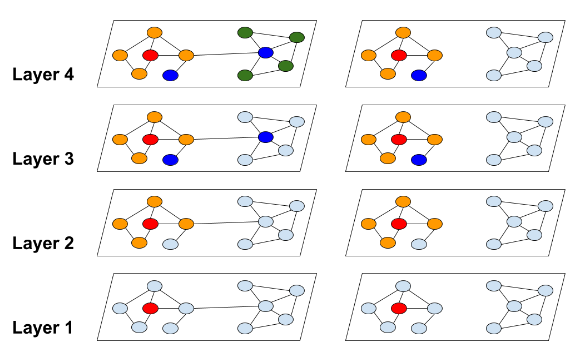

Однако после разделения графа некоторые связи удаляются, что может ограничивать производительность модели из-за необъективной оценки.
Чтобы решить эту проблему, Cluster-GCN также **включает ссылки между кластерами внутри мини-батча**, что приводит к следующей схеме стохастического разделения:

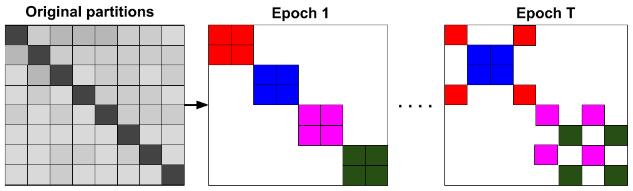

Здесь цвета представляют информацию о смежности, которая поддерживается для каждого батча (которая может быть разной для каждой эпохи).

PyTorch Geometric обеспечивает **двухэтапную реализацию** алгоритма Cluster-GCN:
1. [**`ClusterData`**](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.ClusterData) преобразует объект «Data» в набор подграфов, содержащие `num_parts` частей.
2. Учитывая заданный пользователем `batch_size`, [**`ClusterLoader`**](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.ClusterLoader) реализует стохастическую схема разбиения для создания мини-батчей.

Процедура создания мини-батчей выглядит следующим образом:

In [22]:
from torch_geometric.loader import ClusterData, ClusterLoader

torch.manual_seed(42)
cluster_data = ClusterData(data, num_parts=128)  # 1. Create subgraphs.
train_loader = ClusterLoader(cluster_data, batch_size=32, shuffle=True)  # 2. Stochastic partioning scheme.

print()
total_num_nodes = 0
for step, sub_data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of nodes in the current batch: {sub_data.num_nodes}')
    print(sub_data)
    print()
    total_num_nodes += sub_data.num_nodes

print(f'Iterated over {total_num_nodes} of {data.num_nodes} nodes!')

Computing METIS partitioning...



Step 1:
Number of nodes in the current batch: 4909
Data(x=[4909, 500], y=[4909], train_mask=[4909], val_mask=[4909], test_mask=[4909], edge_index=[2, 15304])

Step 2:
Number of nodes in the current batch: 4936
Data(x=[4936, 500], y=[4936], train_mask=[4936], val_mask=[4936], test_mask=[4936], edge_index=[2, 21072])

Step 3:
Number of nodes in the current batch: 4939
Data(x=[4939, 500], y=[4939], train_mask=[4939], val_mask=[4939], test_mask=[4939], edge_index=[2, 17500])

Step 4:
Number of nodes in the current batch: 4933
Data(x=[4933, 500], y=[4933], train_mask=[4933], val_mask=[4933], test_mask=[4933], edge_index=[2, 15260])

Iterated over 19717 of 19717 nodes!


Done!


Здесь мы разделяем исходный граф на **128 частей** и используем **`batch_size` из 32 подграфов** для формирования мини-батчей.
Как видно, после одной эпохи каждая вершина была замечена ровно один раз.

Самое удобное в Cluster-GCN то, что он не усложняет реализацию модели GNN.

In [23]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

device = 'cuda'
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(500, 16)
  (conv2): GCNConv(16, 3)
)


In [25]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


def train():
    model.train()

    for sub_data in train_loader:  # Iterate over each mini-batch.
        out = model(sub_data.x, sub_data.edge_index)
        loss = criterion(out[sub_data.train_mask],
                         sub_data.y[sub_data.train_mask])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad() 


def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask] == data.y[mask]
        accs.append(int(correct.sum()) / int(mask.sum()))
    return accs


for epoch in range(1, 51):
    loss = train()
    train_acc, val_acc, test_acc = test()
    print(
        f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train: 0.3500, Val Acc: 0.4180, Test Acc: 0.4080
Epoch: 002, Train: 0.6667, Val Acc: 0.5720, Test Acc: 0.6060
Epoch: 003, Train: 0.8833, Val Acc: 0.7200, Test Acc: 0.7330
Epoch: 004, Train: 0.9500, Val Acc: 0.7660, Test Acc: 0.7660
Epoch: 005, Train: 0.9500, Val Acc: 0.7820, Test Acc: 0.7780
Epoch: 006, Train: 0.9500, Val Acc: 0.7760, Test Acc: 0.7680
Epoch: 007, Train: 0.9667, Val Acc: 0.7640, Test Acc: 0.7600
Epoch: 008, Train: 0.9667, Val Acc: 0.7580, Test Acc: 0.7390
Epoch: 009, Train: 0.9333, Val Acc: 0.7440, Test Acc: 0.7270
Epoch: 010, Train: 0.9500, Val Acc: 0.7640, Test Acc: 0.7530
Epoch: 011, Train: 0.9500, Val Acc: 0.7800, Test Acc: 0.7700
Epoch: 012, Train: 0.9500, Val Acc: 0.7760, Test Acc: 0.7670
Epoch: 013, Train: 0.9667, Val Acc: 0.7680, Test Acc: 0.7650
Epoch: 014, Train: 0.9667, Val Acc: 0.7660, Test Acc: 0.7560
Epoch: 015, Train: 0.9667, Val Acc: 0.7700, Test Acc: 0.7720
Epoch: 016, Train: 0.9500, Val Acc: 0.7740, Test Acc: 0.7690
Epoch: 017, Train: 0.950